<a href="https://www.kaggle.com/code/pritam1202/phenotype-gene-analysis?scriptVersionId=201084229" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Reading data

In [2]:
# Dataset containing phenotype embeddings
pheno = pd.read_csv(r'/kaggle/input/phenotype-gene-embeddings/phenotype_embeddings.csv')
pheno.head()

Unnamed: 0                                                  0  \
0           0  Carotenoid and tocopherol levels (beta-caroten...   
1           1                                   Bilirubin levels   
2           2  Sphingolipid levels (SM 14:0Mol%) (sphingomyel...   
3           3   Fasting glucose-related traits (FPG) (D-Glucose)   
4           4     Vitamin D insufficiency (25-Hydroxyvitamin D2)   

                                     gpt_description  \
0  Carotenoids and tocopherols are important clas...   
1  Bilirubin is a yellow pigment that is produced...   
2  Sphingolipids are a class of lipids that play ...   
3  Fasting glucose-related traits, also known as ...   
4  Vitamin D insufficiency, specifically referrin...   

                                           embedding  
0  [0.03543854132294655, -0.002083840314298868, -...  
1  [-0.002501995535567403, -0.03334518149495125, ...  
2  [-0.003154945094138384, -0.016002262011170387,...  
3  [-0.026761554181575775, 0.011279185302555561, ...  
4  [0.004818837624043226, 0.01093713752925396, -0...

In [3]:
pheno.columns

Index(['Unnamed: 0', '0', 'gpt_description', 'embedding'], dtype='object')

In [4]:
pheno.shape

(959, 4)

In [5]:
# Dataset containing gene embeddings
gene = pd.read_csv(r'/kaggle/input/phenotype-gene-embeddings/gene_embeddings.csv')
gene.head()

Unnamed: 0         0                                    gpt_description  \
0           0     ATMIN  The ATMIN gene, also known as ATM interactor (...   
1           1      BCO1  Gene BCO1, also known as beta-carotene oxygena...   
2           2  C16orf46  Gene C16orf46, also known as Chromosome 16 Ope...   
3           3     CDYL2  The gene CDYL2, also known as Chromodomain Y-l...   
4           4     CENPN  The gene CENPN, also known as Centromere Prote...   

                                           embedding  
0  [-0.01672099530696869, 0.025642508640885353, -...  
1  [0.01961715891957283, -0.0013358700089156628, ...  
2  [-0.013213221915066242, 0.008565986528992653, ...  
3  [-0.010155326686799526, 0.007696880027651787, ...  
4  [0.0019102469086647034, -0.01410931721329689, ...

In [6]:
gene.columns

Index(['Unnamed: 0', '0', 'gpt_description', 'embedding'], dtype='object')

In [7]:
gene.shape

(10983, 4)

In [8]:
len((gene['embedding'][0]).split(','))

3072

In [9]:
# Dataset containing phenotype and its gene strings
pheno_gene = pd.read_csv(r'/kaggle/input/phenotype-gene-embeddings/opentargets_step2.for_llm.tsv', sep = '\t')
pheno_gene.head()

row_number                                        description  \
0           1  Carotenoid and tocopherol levels (beta-caroten...   
1           2                                   Bilirubin levels   
2           3                                   Bilirubin levels   
3           4  Sphingolipid levels (SM 14:0Mol%) (sphingomyel...   
4           5   Fasting glucose-related traits (FPG) (D-Glucose)   

                                  symbol_gene_string  \
0  {ATMIN},{BCO1},{C16orf46},{CDYL2},{CENPN},{CMC...   
1  {ATG16L1},{DGKD},{HJURP},{MROH2A},{SAG},{SPP2}...   
2  {ARHGAP4},{ATP6AP1},{AVPR2},{CTAG1A},{CTAG1B},...   
3  {ESR2},{GPHB5},{PPP2R5E},{RHOJ},{SGPP1},{SYNE2...   
4  {ABCB11},{CERS6},{DHRS9},{G6PC2},{LRP2},{NOSTR...   

                                 ensembl_gene_string  
0  {ENSG00000103121},{ENSG00000135697},{ENSG00000...  
1  {ENSG00000072080},{ENSG00000077044},{ENSG00000...  
2  {ENSG00000007350},{ENSG00000013563},{ENSG00000...  
3  {ENSG00000054654},{ENSG00000126785},{ENSG00000...  
4  {ENSG00000073734},{ENSG00000073737},{ENSG00000...

In [10]:
pheno_gene.shape

(851, 4)

In [11]:
# Dataset containing the causal gene for the phenotype in above dataset
ground_truth = pd.read_csv(r'/kaggle/input/phenotype-gene-embeddings/opentargets_step2.labels', sep = '\t')
ground_truth.head()

symbol             gene
0    BCO1  ENSG00000135697
1  UGT1A8  ENSG00000242366
2    G6PD  ENSG00000160211
3   SGPP1  ENSG00000126821
4   G6PC2  ENSG00000152254

In [12]:
ground_truth.shape

(851, 2)

# Dataset creation

### Unique hashing

In [13]:
import hashlib

In [14]:
name = 'pritamchakraborty'
hash_object = hashlib.md5(name.encode())
hash_value = hash_object.hexdigest()
hash_value

'4d69fbe946a2991088aa9242f15452b9'

### Unique dataset extraction

In [15]:
seed = int(hash_value,16) % (10**8) #reducing the number as random state accepts till 2**32 
seed

88799417

In [16]:
# Unique dataset for phenotypes and their gene stringa
seed_data = pheno_gene.sample(500, random_state = seed)
seed_data.shape

(500, 4)

In [17]:
seed_data.head()

row_number                                        description  \
607         608        Type 2 diabetes (type II diabetes mellitus)   
460         461                                    Crohn's disease   
13           14               D-dimer levels (D dimer measurement)   
299         300  Chronic inflammatory diseases (ankylosing spon...   
791         792                treatment: statin use (simvastatin)   

                                    symbol_gene_string  \
607  {CAND2},{ENSG00000289809},{MKRN2},{MKRN2OS},{P...   
460  {ABHD16A},{AIF1},{APOM},{ATP6V1G2},{ATP6V1G2-D...   
13   {ABCA4},{ABCD3},{ALG14},{ARHGAP29},{CNN3},{F3}...   
299  {ASB8},{CCDC184},{COL2A1},{ENDOU},{HDAC7},{OR1...   
791  {APOC1},{APOC2},{APOC4},{APOC4-APOC2},{APOE},{...   

                                   ensembl_gene_string  
607  {ENSG00000075975},{ENSG00000088726},{ENSG00000...  
460  {ENSG00000137310},{ENSG00000166278},{ENSG00000...  
13   {ENSG00000117519},{ENSG00000117525},{ENSG00000...  
299  {ENSG00000005175},{ENSG00000061273},{ENSG00000...  
791  {ENSG00000007047},{ENSG00000007255},{ENSG00000...

In [18]:
seed_data.reset_index(inplace =True)
seed_data.drop(columns=['row_number'],inplace = True)
seed_data.rename(columns={'description':'phenotype'}, inplace=True)

In [19]:
# Unique dataset resembling the previous dataset for the causal genes in the gene strings
seed_ground_truth = ground_truth.sample(500, random_state = seed)
seed_ground_truth.shape

(500, 2)

In [20]:
seed_ground_truth.head()

symbol             gene
607  PPARG  ENSG00000132170
460    TNF  ENSG00000232810
13      F3  ENSG00000117525
299    VDR  ENSG00000111424
791   APOE  ENSG00000130203

In [21]:
seed_ground_truth.reset_index(inplace=True)
seed_ground_truth.head(1)

index symbol             gene
0    607  PPARG  ENSG00000132170

In [22]:
# Checking if both dataset are matching 
if list(seed_data['index'])==list(seed_ground_truth['index']):
    print('Correct dataset seeded')

Correct dataset seeded


In [23]:
#Checking the counts for phenotypes
seed_data['phenotype'].value_counts()

phenotype
Type 2 diabetes (type II diabetes mellitus)                       101
Breast carcinoma                                                   18
Type 2 diabetes (adjusted for BMI) (type II diabetes mellitus)     16
Psoriasis                                                          14
Atrial fibrillation                                                12
                                                                 ... 
Blood metabolite levels (X-13431--nonanoylcarnitine)                1
Renal function-related traits (BUN) (Urea)                          1
skin color (skin pigmentation)                                      1
Blood metabolite levels (myo-inositol)                              1
Metabolite levels (Phe, Tyr) (L-Phenylalanine / L-Tyrosine)         1
Name: count, Length: 213, dtype: int64

In [24]:
# Number of unique phenotypes
seed_data['phenotype'].nunique()

213

There might be duplicates present in the dataset

In [25]:
# Checking duplicates based on phenotype and its corresponding gene string
seed_data[['symbol_gene_string', 'phenotype']].duplicated().sum()

128

In [26]:
# Removing duplicates
seed_data.drop_duplicates(subset=['symbol_gene_string', 'phenotype'],keep='first', inplace =True)
seed_data.shape

(372, 4)

In [27]:
# Checking the count for phenotypes after duplicate removal
seed_data['phenotype'].value_counts()

phenotype
Type 2 diabetes (type II diabetes mellitus)                                                 36
Breast carcinoma                                                                            17
Type 2 diabetes (adjusted for BMI) (type II diabetes mellitus)                              11
HDL Cholesterol (high density lipoprotein cholesterol measurement)                           8
LDL Cholesterol (low density lipoprotein cholesterol measurement)                            8
                                                                                            ..
Fasting plasma glucose (D-Glucose)                                                           1
asparagine - M34283 (L-Asparagine)                                                           1
reticulocyte volume                                                                          1
Age-related diseases, mortality and associated endophenotypes (cerebrovascular accident)     1
Metabolite levels (Phe, Tyr) (L-Phenylal

Checking for the remaining repetitions in phenotypes

In [28]:
seed_data[seed_data['phenotype']=='Type 2 diabetes (type II diabetes mellitus)'][['symbol_gene_string','index']]

symbol_gene_string  index
0    {CAND2},{ENSG00000289809},{MKRN2},{MKRN2OS},{P...    607
11   {COL13A1},{FAM241B},{HK1},{HKDC1},{MACROH2A2},...    514
19   {ACADS},{ANAPC5},{C12orf43},{CABP1},{CAMKK2},{...    555
24   {BLOC1S4},{C4orf50},{CRMP1},{ENSG00000170846},...    617
33   {ADA},{CCN5},{FITM2},{GDAP1L1},{HNF4A},{JPH2},...    590
43   {ABCC8},{KCNC1},{KCNJ11},{MYOD1},{NCR3LG1},{NU...    533
70   {ACADVL},{ACAP1},{ALOX12},{ASGR1},{ASGR2},{BCL...    558
74   {ABHD1},{AGBL5},{ATRAID},{BABAM2},{C2orf16},{C...    583
76   {BLOC1S3},{CCDC61},{CKM},{DMPK},{DMWD},{EML2},...    573
85    {AARD},{EIF3H},{MED30},{RAD21},{SLC30A8},{UTP23}    670
88   {BLOC1S4},{C4orf50},{CRMP1},{ENSG00000170846},...    627
96   {AK3},{CDC37L1},{GLIS3},{PLPP6},{SLC1A1},{SPAT...    689
106  {ARF5},{FSCN3},{GCC1},{GRM8},{PAX4},{SND1},{ZN...    658
120  {MKRN2},{MKRN2OS},{PPARG},{RAF1},{SYN2},{TAMM4...    356
121            {GIN1},{MACIR},{NUDT12},{PAM},{PPIP5K2}    644
126  {BLOC1S4},{C4orf50},{CRMP1},{ENSG00000170846},...    614
129  {BLOC1S3},{CCDC61},{CKM},{DMPK},{DMWD},{EML2},...    577
147  {ADA},{CCN5},{FITM2},{GDAP1L1},{HNF4A},{JPH2},...    596
170  {ASCL4},{CMKLR1},{CORO1C},{FICD},{ISCU},{PRDM4...    547
174  {BMP6},{CAGE1},{DSP},{RIOK1},{RREB1},{SNRNP48}...    651
184  {ASCL2},{C11orf21},{CD81},{CTSD},{ENSG00000250...    523
202  {GIN1},{MACIR},{PAM},{PPIP5K2},{SLCO4C1},{SLCO...    635
205  {AEBP1},{BLVRA},{CAMK2B},{COA1},{DBNL},{DDX56}...    657
213                                    {MC4R},{PMAIP1}    563
243  {ARF5},{FSCN3},{GCC1},{GRM8},{LRRC4},{PAX4},{S...    659
249     {CAGE1},{DSP},{RIOK1},{RREB1},{SNRNP48},{SSR1}    645
256  {ATP6V1B2},{CSGALNACT1},{INTS10},{LPL},{LZTS1}...    666
281                  {DEUP1},{FAT3},{MTNR1B},{SLC36A4}    542
285  {BTBD9},{DNAH8},{GLO1},{GLP1R},{KCNK16},{KCNK1...    463
304  {ACADS},{ANAPC5},{C12orf43},{CABP1},{CAMKK2},{...    553
331  {ANKDD1B},{ANKRD31},{CERT1},{HMGCR},{POC5},{PO...    633
380  {BLOC1S3},{CCDC61},{CKM},{DMPK},{DMWD},{EML2},...    575
382  {EFCAB6},{MPPED1},{PARVB},{PARVG},{PNPLA3},{PN...    602
424           {GIN1},{MACIR},{PAM},{PPIP5K2},{SLCO6A1}    637
483    {DNAJB6},{LMBR1},{MNX1},{NOM1},{PTPRN2},{UBE3C}    664
499           {AARD},{EIF3H},{RAD21},{SLC30A8},{UTP23}    667

In [29]:
list(seed_data[seed_data['index']==617]['symbol_gene_string'])

['{BLOC1S4},{C4orf50},{CRMP1},{ENSG00000170846},{ENSG00000284684},{EVC},{JAKMIP1},{KIAA0232},{MAN2B2},{MRFAP1},{MRFAP1L1},{PPP2R2C},{S100P},{WFS1}']

In [30]:
list(seed_data[seed_data['index']==614]['symbol_gene_string'])

['{BLOC1S4},{C4orf50},{CRMP1},{ENSG00000170846},{ENSG00000284684},{EVC},{JAKMIP1},{MAN2B2},{MRFAP1},{MRFAP1L1},{PPP2R2C},{S100P},{WFS1}']

There seems to be some modification present in the gene string. Keeping them in the dataset as they are required.

#### Creating the dataset with phenotype and its causal gene

In [31]:
# Merging the phenotype and the causal gene dataset
causal_gene_pheno = pd.merge(seed_data, seed_ground_truth, on='index',how='inner')
causal_gene_pheno.head()

index                                          phenotype  \
0    607        Type 2 diabetes (type II diabetes mellitus)   
1    460                                    Crohn's disease   
2     13               D-dimer levels (D dimer measurement)   
3    299  Chronic inflammatory diseases (ankylosing spon...   
4    791                treatment: statin use (simvastatin)   

                                  symbol_gene_string  \
0  {CAND2},{ENSG00000289809},{MKRN2},{MKRN2OS},{P...   
1  {ABHD16A},{AIF1},{APOM},{ATP6V1G2},{ATP6V1G2-D...   
2  {ABCA4},{ABCD3},{ALG14},{ARHGAP29},{CNN3},{F3}...   
3  {ASB8},{CCDC184},{COL2A1},{ENDOU},{HDAC7},{OR1...   
4  {APOC1},{APOC2},{APOC4},{APOC4-APOC2},{APOE},{...   

                                 ensembl_gene_string symbol             gene  
0  {ENSG00000075975},{ENSG00000088726},{ENSG00000...  PPARG  ENSG00000132170  
1  {ENSG00000137310},{ENSG00000166278},{ENSG00000...    TNF  ENSG00000232810  
2  {ENSG00000117519},{ENSG00000117525},{ENSG00000...     F3  ENSG00000117525  
3  {ENSG00000005175},{ENSG00000061273},{ENSG00000...    VDR  ENSG00000111424  
4  {ENSG00000007047},{ENSG00000007255},{ENSG00000...   APOE  ENSG00000130203

In [32]:
# Dropping unwanted columns and renaming some columns
causal_gene_pheno.drop(columns=['index','ensembl_gene_string','gene'],inplace=True)
causal_gene_pheno.rename(columns={'symbol':'causal_gene'}, inplace=True)

In [33]:
# Cleaning and expanding the gene string row wise for each phenotype
causal_gene_pheno['symbol_gene_string'] = causal_gene_pheno['symbol_gene_string'].str.replace(r'[{}]', '', regex=True)
causal_gene_pheno['symbol_gene_string'] = causal_gene_pheno['symbol_gene_string'].str.split(',')
causal_gene_pheno = causal_gene_pheno.explode('symbol_gene_string').reset_index(drop=True)
causal_gene_pheno.tail()

phenotype symbol_gene_string  \
5839  Type 2 diabetes (type II diabetes mellitus)               AARD   
5840  Type 2 diabetes (type II diabetes mellitus)              EIF3H   
5841  Type 2 diabetes (type II diabetes mellitus)              RAD21   
5842  Type 2 diabetes (type II diabetes mellitus)            SLC30A8   
5843  Type 2 diabetes (type II diabetes mellitus)              UTP23   

     causal_gene  
5839     SLC30A8  
5840     SLC30A8  
5841     SLC30A8  
5842     SLC30A8  
5843     SLC30A8

In [34]:
causal_gene_pheno.shape

(5844, 3)

In [35]:
#Labelling the phenotype causal gene pair as 1 and phenotype non-causal gene pair as 0
causal_gene_pheno['causal'] = [1 if causal_gene_pheno['symbol_gene_string'][i] == causal_gene_pheno['causal_gene'][i] else 0 for i in range(len(causal_gene_pheno['causal_gene']))]
causal_gene_pheno.head()

phenotype symbol_gene_string causal_gene  \
0  Type 2 diabetes (type II diabetes mellitus)              CAND2       PPARG   
1  Type 2 diabetes (type II diabetes mellitus)    ENSG00000289809       PPARG   
2  Type 2 diabetes (type II diabetes mellitus)              MKRN2       PPARG   
3  Type 2 diabetes (type II diabetes mellitus)            MKRN2OS       PPARG   
4  Type 2 diabetes (type II diabetes mellitus)              PPARG       PPARG   

   causal  
0       0  
1       0  
2       0  
3       0  
4       1

In [36]:
# Renaming and droping some columns
causal_gene_pheno.drop(columns='causal_gene',inplace=True)
causal_gene_pheno.rename(columns={'symbol_gene_string':'gene_composition'},inplace=True)
causal_gene_pheno.head()

phenotype gene_composition  causal
0  Type 2 diabetes (type II diabetes mellitus)            CAND2       0
1  Type 2 diabetes (type II diabetes mellitus)  ENSG00000289809       0
2  Type 2 diabetes (type II diabetes mellitus)            MKRN2       0
3  Type 2 diabetes (type II diabetes mellitus)          MKRN2OS       0
4  Type 2 diabetes (type II diabetes mellitus)            PPARG       1

### Filtering and transforming the embeddings

#### Extracting the embeddings of the phenotypes present in the unique dataset

In [37]:
# Checking for phenotypes whose embeddings are not present
pheno_missing = causal_gene_pheno[~causal_gene_pheno['phenotype'].isin(pheno['0'])]['phenotype']
print(f'No. of phenotypes missing --> {pheno_missing.nunique()}')
pheno_missing.unique()

No. of phenotypes missing --> 10


array(["Chronic inflammatory diseases (ankylosing spondylitis, Crohn's disease, psoriasis, primary sclerosing cholangitis, ulcerative colitis) [subset analysis]",
       'High cholesterol (Hypercholesterolemia)',
       'Metabolic syndrome [HDLC-WC]',
       'Breast cancer illnesses of mother (breast carcinoma)',
       'Advanced age-related macular degeneration',
       'Heart attack vascular/heart problems diagnosed by doctor (myocardial infarction)',
       'Fasting Glucose (D-Glucose)',
       'Fasting plasma glucose (D-Glucose)', 'Pulmonary embolism +/- dvt',
       'Blood clot in the leg (dvt) (deep vein thrombosis)'], dtype=object)

Embeddings for 10 phenotypes seems to missing. Will drop them while merging as they won't be helpful in analysis. 

In [38]:
#Extracting the phenotype embeddings that are required 
pheno_filtered = pheno[pheno['0'].isin(causal_gene_pheno['phenotype'])]
pheno_filtered = pheno_filtered.drop(columns=['Unnamed: 0','gpt_description'])
pheno_filtered.reset_index(drop=True,inplace=True)
pheno_filtered.head()

0  \
0  Sphingolipid levels (SM 14:0Mol%) (sphingomyel...   
1   Fasting glucose-related traits (FPG) (D-Glucose)   
2                                  Phosphorus levels   
3                      Magnesium levels (Magneseium)   
4                                   Magnesium levels   

                                           embedding  
0  [-0.003154945094138384, -0.016002262011170387,...  
1  [-0.026761554181575775, 0.011279185302555561, ...  
2  [-0.00845419429242611, -0.008621890097856522, ...  
3  [0.018087241798639297, 0.005338727496564388, 0...  
4  [0.02048342488706112, -0.014497559517621994, -...

In [39]:
pheno_filtered.shape

(203, 2)

#### Extracting the embeddings of genes present in unique dataset

In [40]:
# Checking for genes whose embeddings are not present
gene_missing = causal_gene_pheno[~causal_gene_pheno['gene_composition'].isin(gene['0'])]['gene_composition']
gene_missing.unique()

array([''], dtype=object)

Embeddings of all genes seems to be present. But since some the missing phenotypes are removed, their corresponding genes will also also be not considered. **This is done to ensure that noises are not present while performing dimensionality reduction.** 

In [41]:
# Filtering the gene embedidngs based on the filtered phenotypes
available_phenotype = causal_gene_pheno[~causal_gene_pheno['phenotype'].isin(pheno_missing)]
gene_filtered = gene[gene['0'].isin(available_phenotype['gene_composition'])]
gene_filtered = gene_filtered.drop(columns=['Unnamed: 0','gpt_description'])
gene_filtered.reset_index(drop=True,inplace=True)
gene_filtered.head()

0                                          embedding
0     ATMIN  [-0.01672099530696869, 0.025642508640885353, -...
1      BCO1  [0.01961715891957283, -0.0013358700089156628, ...
2  C16orf46  [-0.013213221915066242, 0.008565986528992653, ...
3     CDYL2  [-0.010155326686799526, 0.007696880027651787, ...
4     CENPN  [0.0019102469086647034, -0.01410931721329689, ...

In [42]:
gene_filtered.shape

(3331, 2)

### Tranforming the embeddings

In [43]:
# Concating the phenotype and gene embedding datasets 
pheno_gene_embed = pd.concat([pheno_filtered,gene_filtered], axis=0).reset_index(drop=True)
pheno_gene_embed.head()

0  \
0  Sphingolipid levels (SM 14:0Mol%) (sphingomyel...   
1   Fasting glucose-related traits (FPG) (D-Glucose)   
2                                  Phosphorus levels   
3                      Magnesium levels (Magneseium)   
4                                   Magnesium levels   

                                           embedding  
0  [-0.003154945094138384, -0.016002262011170387,...  
1  [-0.026761554181575775, 0.011279185302555561, ...  
2  [-0.00845419429242611, -0.008621890097856522, ...  
3  [0.018087241798639297, 0.005338727496564388, 0...  
4  [0.02048342488706112, -0.014497559517621994, -...

In [44]:
pheno_gene_embed.shape

(3534, 2)

In [45]:
# Checking for duplicates
pheno_gene_embed.duplicated().sum()

0

#### Performing dimensionality reduction of the embeddings

The target here is to reduce the 3072 dimensional embeddings to 2 dimensional embeddings for easier visualisation

In [46]:
type(pheno_gene_embed['embedding'][0])

str

In [47]:
# Splitting the embeddings to 3072 columns
embeddings = pheno_gene_embed['embedding'].replace(r'[\[\]]','',regex=True).str.split(', ', expand=True)

In [48]:
embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Columns: 3072 entries, 0 to 3071
dtypes: object(3072)
memory usage: 82.8+ MB


In [49]:
#Changing the data type to float for the embeddings
embeddings = embeddings.astype(float)
embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Columns: 3072 entries, 0 to 3071
dtypes: float64(3072)
memory usage: 82.8 MB


In [50]:
embeddings.head()

0         1         2         3         4         5         6     \
0 -0.003155 -0.016002 -0.010256 -0.004018  0.024438 -0.023555  0.016858   
1 -0.026762  0.011279 -0.009210  0.005537  0.006260 -0.000889  0.008220   
2 -0.008454 -0.008622 -0.005858  0.019175  0.006453 -0.014225  0.012282   
3  0.018087  0.005339  0.000831  0.018030  0.016684 -0.001548 -0.007180   
4  0.020483 -0.014498 -0.005963  0.006632  0.015951 -0.006747 -0.001829   

       7         8         9     ...      3062      3063      3064      3065  \
0 -0.032140  0.026313 -0.005525  ...  0.007403 -0.000427  0.020607 -0.005237   
1 -0.031980  0.014113 -0.033523  ... -0.011941 -0.007301  0.008066 -0.009994   
2 -0.059723  0.024634 -0.028867  ... -0.012699 -0.019846  0.016642  0.000486   
3 -0.058864  0.037440 -0.028926  ... -0.015142 -0.017201  0.019203  0.008181   
4 -0.058775  0.026112 -0.014128  ... -0.008985 -0.013183  0.013298  0.016043   

       3066      3067      3068      3069      3070      3071  
0  0.010521 -0.024465  0.015500 -0.003705  0.009434  0.007852  
1  0.004631 -0.016221  0.022340 -0.003059 -0.015257  0.005135  
2  0.003441 -0.026461  0.041033  0.002027 -0.012097 -0.007176  
3  0.004551 -0.016430  0.019376  0.002777 -0.014382 -0.015982  
4  0.002028 -0.016032  0.018234  0.003705 -0.013148 -0.017150  

[5 rows x 3072 columns]

In [51]:
# scaling the embeddings for proper distribution
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

In [52]:
from sklearn.decomposition import PCA

In [53]:
# Initiating the PCA module and fitting the data
pca =PCA()
principal_components = pca.fit_transform(embeddings_scaled)
principal_components.shape

(3534, 3072)

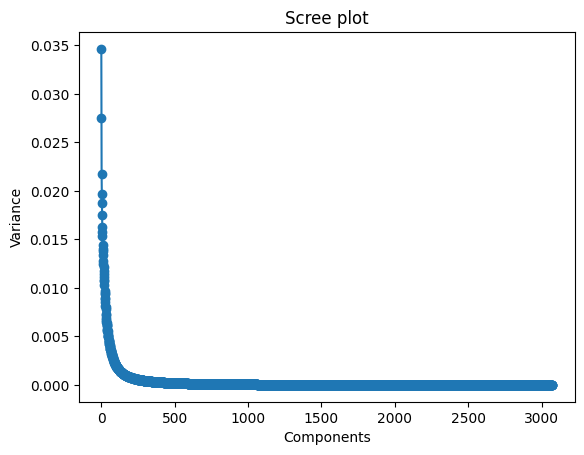

In [54]:
# Plottig the amount of variance captured by each principal component axis
components = np.arange(pca.n_components_) + 1
plt.plot(components, pca.explained_variance_ratio_, 'o-')
plt.xlabel('Components')
plt.ylabel('Variance')
plt.title('Scree plot')
plt.show()

In [55]:
#Percent of variance captured by first two principal components
sum(pca.explained_variance_ratio_[:2])*100

6.216395440486903

The first two principal components can only capture 6.2% of the variance.<br>Checking t-SNE for dimensionality reduction with two components. 

In [56]:
from sklearn.manifold import TSNE

In [57]:
# Initiating the module with 2 components and fitting the data
tsne = TSNE(n_components=2)
tsne_components = tsne.fit_transform(embeddings_scaled)
tsne_components.shape

(3534, 2)

Checking the trustworthiness score for both PCA and t-SNE for 2 dimensions

In [58]:
from sklearn.manifold import trustworthiness

In [59]:
pca_trust = trustworthiness(embeddings_scaled, principal_components[:,:2])
tsne_trust = trustworthiness(embeddings_scaled, tsne_components)
print(f'Trustworthiness score --> PCA:{pca_trust}, t-SNE:{tsne_trust}')

Trustworthiness score --> PCA:0.6773891643642618, t-SNE:0.9729690606220233


The trustworthiness score is larger for t-SNE with 2 dimensions. The t-SNE is able to capture 97% of the local relationship in higher dimensions after reduced to 2, whereas PCA is only able to capture only 67%.

Moving forward with the t-SNE reduced dimensions

In [60]:
# Adding the reduced dimensions to corresponding phenotype and genes
pheno_gene_embed['tsne_1'] = tsne_components[:,0]
pheno_gene_embed['tsne_2'] = tsne_components[:,1]
pheno_gene_embed.head()

0  \
0  Sphingolipid levels (SM 14:0Mol%) (sphingomyel...   
1   Fasting glucose-related traits (FPG) (D-Glucose)   
2                                  Phosphorus levels   
3                      Magnesium levels (Magneseium)   
4                                   Magnesium levels   

                                           embedding     tsne_1     tsne_2  
0  [-0.003154945094138384, -0.016002262011170387,... -28.874640 -55.029984  
1  [-0.026761554181575775, 0.011279185302555561, ...   1.448516 -34.256599  
2  [-0.00845419429242611, -0.008621890097856522, ... -30.035120 -63.036098  
3  [0.018087241798639297, 0.005338727496564388, 0... -30.781528 -64.193893  
4  [0.02048342488706112, -0.014497559517621994, -... -30.790514 -64.172775

In [61]:
#converting the values of embedded column to list data type which will be used later
import ast
pheno_gene_embed['embedding'] = pheno_gene_embed['embedding'].apply(ast.literal_eval)

## Final dataset

In [62]:
# Adding the phenotype embeddings to the dataset
# Inner join is used as embeddings of some phenotype are missing
final_dataset = pd.merge(causal_gene_pheno, pheno_gene_embed, left_on = 'phenotype', right_on = '0', how = 'inner')
final_dataset.head()

phenotype gene_composition  causal  \
0  Type 2 diabetes (type II diabetes mellitus)            CAND2       0   
1  Type 2 diabetes (type II diabetes mellitus)  ENSG00000289809       0   
2  Type 2 diabetes (type II diabetes mellitus)            MKRN2       0   
3  Type 2 diabetes (type II diabetes mellitus)          MKRN2OS       0   
4  Type 2 diabetes (type II diabetes mellitus)            PPARG       1   

                                             0  \
0  Type 2 diabetes (type II diabetes mellitus)   
1  Type 2 diabetes (type II diabetes mellitus)   
2  Type 2 diabetes (type II diabetes mellitus)   
3  Type 2 diabetes (type II diabetes mellitus)   
4  Type 2 diabetes (type II diabetes mellitus)   

                                           embedding     tsne_1     tsne_2  
0  [-0.008776935748755932, 0.0038059279322624207,... -39.246365 -57.288761  
1  [-0.008776935748755932, 0.0038059279322624207,... -39.246365 -57.288761  
2  [-0.008776935748755932, 0.0038059279322624207,... -39.246365 -57.288761  
3  [-0.008776935748755932, 0.0038059279322624207,... -39.246365 -57.288761  
4  [-0.008776935748755932, 0.0038059279322624207,... -39.246365 -57.288761

In [63]:
# Dropping and renaming some columns
final_dataset.drop(columns='0', inplace=True)
final_dataset.rename(columns={'embedding':'pheno_embedding', 'tsne_1':'pheno_tsne_1', 'tsne_2':'pheno_tsne_2'},inplace=True)

In [64]:
final_dataset.isnull().sum()

phenotype           0
gene_composition    0
causal              0
pheno_embedding     0
pheno_tsne_1        0
pheno_tsne_2        0
dtype: int64

In [65]:
# Adding the gene embeddings to the dataset
final_dataset = pd.merge(final_dataset, pheno_gene_embed, left_on = 'gene_composition', right_on = '0', how = 'inner')
final_dataset.head()

phenotype gene_composition  causal  \
0  Type 2 diabetes (type II diabetes mellitus)            CAND2       0   
1  Type 2 diabetes (type II diabetes mellitus)  ENSG00000289809       0   
2  Type 2 diabetes (type II diabetes mellitus)            MKRN2       0   
3  Type 2 diabetes (type II diabetes mellitus)          MKRN2OS       0   
4  Type 2 diabetes (type II diabetes mellitus)            PPARG       1   

                                     pheno_embedding  pheno_tsne_1  \
0  [-0.008776935748755932, 0.0038059279322624207,...    -39.246365   
1  [-0.008776935748755932, 0.0038059279322624207,...    -39.246365   
2  [-0.008776935748755932, 0.0038059279322624207,...    -39.246365   
3  [-0.008776935748755932, 0.0038059279322624207,...    -39.246365   
4  [-0.008776935748755932, 0.0038059279322624207,...    -39.246365   

   pheno_tsne_2                0  \
0    -57.288761            CAND2   
1    -57.288761  ENSG00000289809   
2    -57.288761            MKRN2   
3    -57.288761          MKRN2OS   
4    -57.288761            PPARG   

                                           embedding    tsne_1     tsne_2  
0  [0.0015132392290979624, 0.009684731252491474, ...  1.527184  43.051624  
1  [-0.021066203713417053, 0.03844643384218216, -... -4.295242  86.582314  
2  [0.008897287771105766, -0.013872249983251095, ...  1.473026  52.293861  
3  [0.0050848089158535, -0.011400744318962097, -0...  1.455780  52.184788  
4  [-0.02626008540391922, 0.03801301494240761, -0...  9.321151 -34.420490

In [66]:
# Dropping and renaming some columns
final_dataset.drop(columns='0', inplace=True)
final_dataset.rename(columns={'embedding':'gene_embedding', 'tsne_1':'gene_tsne_1', 'tsne_2':'gene_tsne_2'},inplace=True)

In [67]:
final_dataset.shape

(5627, 9)

#### The final unique dataset

In [68]:
final_dataset.head()

phenotype gene_composition  causal  \
0  Type 2 diabetes (type II diabetes mellitus)            CAND2       0   
1  Type 2 diabetes (type II diabetes mellitus)  ENSG00000289809       0   
2  Type 2 diabetes (type II diabetes mellitus)            MKRN2       0   
3  Type 2 diabetes (type II diabetes mellitus)          MKRN2OS       0   
4  Type 2 diabetes (type II diabetes mellitus)            PPARG       1   

                                     pheno_embedding  pheno_tsne_1  \
0  [-0.008776935748755932, 0.0038059279322624207,...    -39.246365   
1  [-0.008776935748755932, 0.0038059279322624207,...    -39.246365   
2  [-0.008776935748755932, 0.0038059279322624207,...    -39.246365   
3  [-0.008776935748755932, 0.0038059279322624207,...    -39.246365   
4  [-0.008776935748755932, 0.0038059279322624207,...    -39.246365   

   pheno_tsne_2                                     gene_embedding  \
0    -57.288761  [0.0015132392290979624, 0.009684731252491474, ...   
1    -57.288761  [-0.021066203713417053, 0.03844643384218216, -...   
2    -57.288761  [0.008897287771105766, -0.013872249983251095, ...   
3    -57.288761  [0.0050848089158535, -0.011400744318962097, -0...   
4    -57.288761  [-0.02626008540391922, 0.03801301494240761, -0...   

   gene_tsne_1  gene_tsne_2  
0     1.527184    43.051624  
1    -4.295242    86.582314  
2     1.473026    52.293861  
3     1.455780    52.184788  
4     9.321151   -34.420490

# Analysis

In [69]:
final_dataset['phenotype'].nunique()

203

In [70]:
# Total number of causal genes for a phenotype 
dummy_causal_gene = final_dataset[(final_dataset['causal']==1) & (final_dataset['phenotype']=='Type 2 diabetes (type II diabetes mellitus)')][['phenotype','gene_composition']]
dummy_causal_gene.shape

(36, 2)

In [71]:
# Number of unique casual genes for that particular phenotype
dummy_causal_gene['gene_composition'].nunique()

24

In [72]:
dummy_causal_gene.duplicated().sum()

12

There seems to be repetition of causal genes.<br>Checking for reoccurances.

In [73]:
# Detecting number of duplicates in causal gene for their respective phenotype
causal_genes = final_dataset[final_dataset['causal']==1][['phenotype','gene_composition']] #Extracting the dataset of just the causal genes and their phenotype
causal_genes.duplicated().sum()

19

In [74]:
# Dropping the duplicates
causal_genes = causal_genes.drop_duplicates(keep='first')

In [75]:
# Checking the number of phenotypes that have more than one causal gene
causal_gene_count = causal_genes.groupby('phenotype').agg({'gene_composition':'count'}).reset_index() # grouping by the count of causal gene
causal_gene_count = causal_gene_count.sort_values(by='gene_composition', ascending=False) # sorting wrt count of causal gene
causal_gene_count.rename(columns={'gene_composition':'causal_gene_count'},inplace=True)
count = causal_gene_count[causal_gene_count['causal_gene_count'] > 1].shape[0]
print(f'{count} Phenotypes have more than one causal gene -->')
causal_gene_count[causal_gene_count['causal_gene_count'] > 1]

46 Phenotypes have more than one causal gene -->


phenotype  causal_gene_count
142        Type 2 diabetes (type II diabetes mellitus)                 24
50                                    Breast carcinoma                 16
141  Type 2 diabetes (adjusted for BMI) (type II di...                 11
85   LDL Cholesterol (low density lipoprotein chole...                  8
73   HDL Cholesterol (high density lipoprotein chol...                  8
176          metabolite: glycine (glycine measurement)                  6
12                                 Atrial fibrillation                  6
79                                        Hypertension                  5
139                                  Total Cholesterol                  4
181                       platelet crit (plateletcrit)                  4
52   Cardiovascular disease (cardiovascular system ...                  4
156             arthrosis of hip (osteoarthritis, hip)                  4
140           Triglycerides (triglyceride measurement)                  4
51                                      Calcium levels                  3
122                               Rheumatoid arthritis                  3
74   HDL cholesterol (high density lipoprotein chol...                  3
160    calculus of kidney and ureter (nephrolithiasis)                  3
57                             Coronary artery disease                  3
161                 coffee intake (coffee consumption)                  3
15   Blood lipid (HDL, LDL, TG, PP, …) (lipid measu...                  3
158  average weekly red wine intake (alcohol consum...                  2
81                                          Iron serum                  2
159  bring up phlegm/sputum/mucus on most days (bri...                  2
83    Ischemic heart disease (coronary artery disease)                  2
112                                          Psoriasis                  2
49                    Breast cancer (breast carcinoma)                  2
169        leg predicted mass (right) (lean body mass)                  2
58   Coronary artery disease (myocardial infarction...                  2
60                                     Crohn's disease                  2
64                    Depression (unipolar depression)                  2
66   Disorders of lipoid metabolism (Disorder of li...                  2
72                                                Gout                  2
68                              Essential hypertension                  2
168                       isobutyrylcarnitine - M33441                  2
146                           Urate levels (Uric acid)                  2
124                                      Schizophrenia                  2
106                                  Phosphorus levels                  2
111               Prostate cancer (prostate carcinoma)                  2
195                 worry too long (worry measurement)                  2
14   Blood clot in the leg, DVT (deep vein thrombosis)                  2
5    Age-related diseases, mortality and associated...                  2
6    Age-related diseases, mortality and associated...                  2
98                               Myocardial infarction                  2
121                         Retinol levels (Vitamin A)                  2
29   Blood metabolite levels (glutaroyl carnitine) ...                  2
26                   Blood metabolite levels (betaine)                  2

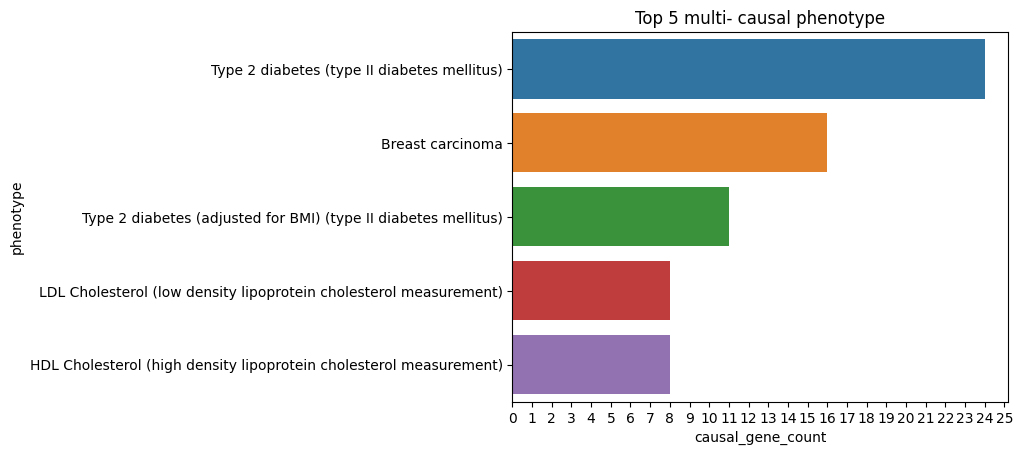

In [76]:
# Plotting the top 5 phenotype that have the highest number of causal gene
sns.barplot(y=causal_gene_count['phenotype'][:5],x=causal_gene_count['causal_gene_count'][:5])
plt.title('Top 5 multi- causal phenotype')
plt.xticks(np.arange(0,26))
plt.show()

In [77]:
# Checking the number of causal genes that have more than one phenotype
gene_pheno_count = causal_genes.groupby('gene_composition').agg({'phenotype':'count'}).reset_index() # grouping by the count of phenotypes
gene_pheno_count = gene_pheno_count.sort_values(by='phenotype', ascending=False) # sorting by the count of phenotypes
gene_pheno_count.rename(columns={'phenotype':'phenotype_count', 'gene_composition':'causal_gene'},inplace=True)
count = gene_pheno_count[gene_pheno_count['phenotype_count'] > 1].shape[0]
print(f'{count} genes are causal to more than one phenotype -->')
gene_pheno_count[gene_pheno_count['phenotype_count'] > 1]

48 genes are causal to more than one phenotype -->


causal_gene  phenotype_count
114       HMGCR                7
107     GUCY1B1                7
77           F2                6
176       PCSK9                5
67         DRD2                4
185       PPARG                4
200     SLC12A3                4
121       IL12B                4
116       HNF4A                3
132      KCNJ11                3
234         TNF                3
124         IL5                3
122       IL23A                3
206    SLC22A12                2
112         HFE                2
212     SLC30A8                2
115       HNF1A                2
49         COMT                2
42         CD80                2
0         ABCA1                2
205    SLC22A11                2
99        GLP1R                2
93         GCKR                2
174         PAM                2
175        PAX4                2
69         ESR1                2
179       PHGDH                2
74          F10                2
86         FUT2                2
188        PSPH                2
96         GIPR                2
111        HCN4                2
182      PNPLA3                2
5           ACE                2
151        MC4R                2
19      ALDH1L1                2
131       KCNH2                2
133       KCNK3                2
146         LPL                2
8         ADH1B                2
22         ALPL                2
245        WFS1                2
238       TUBB1                2
25       ANKLE1                2
29           AR                2
139        LDLR                2
27         APOE                2
30         ARSA                2

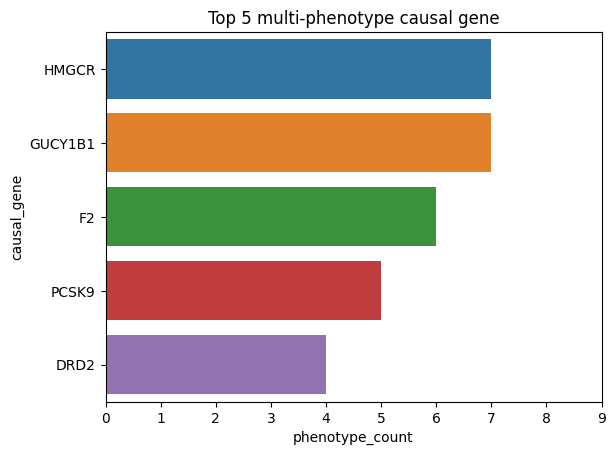

In [78]:
# Plotting the top 5 causal gene that have the highest number of phenotypes
sns.barplot(y=gene_pheno_count['causal_gene'][:5],x=gene_pheno_count['phenotype_count'][:5])
plt.title('Top 5 multi-phenotype causal gene')
plt.xticks(np.arange(0,10))
plt.show()

In [79]:
list(causal_genes[causal_genes['gene_composition']=='HMGCR']['phenotype'])

['Age-related diseases, mortality and associated endophenotypes (heart failure)',
 'treatment: statin use (total cholesterol measurement)',
 'Disorders of lipoid metabolism (Disorder of lipid metabolism)',
 'Age-related diseases, mortality and associated endophenotypes (cerebrovascular accident)',
 'LDL Cholesterol (low density lipoprotein cholesterol measurement)',
 'Age-related diseases, mortality and associated endophenotypes (diabetes mellitus)',
 'Age-related diseases, mortality and associated endophenotypes (atrial fibrillation)']

### Calculating similarities between phenotype and genes

There were repeating genes in the gene string of phenotypes indicating repeating combinations of phenotype and gene. Removing the duplicated values based on phenotype, gene and causal label

In [80]:
# Removing duplicates
similarity_dataset = final_dataset.drop_duplicates(subset=['phenotype','gene_composition','causal'], keep = 'first').reset_index(drop=True)
similarity_dataset.shape

(5303, 9)

In [81]:
# Renaming columns
similarity_dataset = similarity_dataset.drop(columns=['pheno_tsne_1','pheno_tsne_2','gene_tsne_1','gene_tsne_2'])
similarity_dataset.head(1)

phenotype gene_composition  causal  \
0  Type 2 diabetes (type II diabetes mellitus)            CAND2       0   

                                     pheno_embedding  \
0  [-0.008776935748755932, 0.0038059279322624207,...   

                                      gene_embedding  
0  [0.0015132392290979624, 0.009684731252491474, ...

#### Cosine distance (for directional similarity)

In [82]:
from sklearn.metrics.pairwise import cosine_similarity as cosim

In [83]:
# Creating a function to calculate cosine similarity
def cos_sim(A,B):
    vec1 = np.array(A).reshape(1,-1) # changing the shape of the input data for the cosine_similarity function
    vec2 = np.array(B).reshape(1,-1)
    out=cosim(vec1,vec2)
    return out

In [84]:
# Calculating the cosine distance (1-cosine similarity) and assigning the values to a column
similarity_dataset['cosine_distance'] = 1 - np.vectorize(cos_sim)(similarity_dataset['pheno_embedding'], similarity_dataset['gene_embedding']) #vectorizing the function as the input are columns

#### Euclidean distance (for magnitude similarity)

In [85]:
from sklearn.metrics.pairwise import euclidean_distances

In [86]:
# Creating a function to calculate euclidean distance
def euc_dis(A,B):
    vec1 = np.array(A).reshape(1,-1) # changing the shape of the input data for the euclidean_distances function
    vec2 = np.array(B).reshape(1,-1)
    out=euclidean_distances(vec1,vec2)
    return out

In [87]:
# Calculating the euclidean distance and assigning the values to a column
similarity_dataset['euclidean_distance'] = np.vectorize(euc_dis)(similarity_dataset['pheno_embedding'], similarity_dataset['gene_embedding']) #vectorizing the function as the input are columns

In [88]:
similarity_dataset.head()

phenotype gene_composition  causal  \
0  Type 2 diabetes (type II diabetes mellitus)            CAND2       0   
1  Type 2 diabetes (type II diabetes mellitus)  ENSG00000289809       0   
2  Type 2 diabetes (type II diabetes mellitus)            MKRN2       0   
3  Type 2 diabetes (type II diabetes mellitus)          MKRN2OS       0   
4  Type 2 diabetes (type II diabetes mellitus)            PPARG       1   

                                     pheno_embedding  \
0  [-0.008776935748755932, 0.0038059279322624207,...   
1  [-0.008776935748755932, 0.0038059279322624207,...   
2  [-0.008776935748755932, 0.0038059279322624207,...   
3  [-0.008776935748755932, 0.0038059279322624207,...   
4  [-0.008776935748755932, 0.0038059279322624207,...   

                                      gene_embedding  cosine_distance  \
0  [0.0015132392290979624, 0.009684731252491474, ...         0.700132   
1  [-0.021066203713417053, 0.03844643384218216, -...         0.777386   
2  [0.008897287771105766, -0.013872249983251095, ...         0.706709   
3  [0.0050848089158535, -0.011400744318962097, -0...         0.768640   
4  [-0.02626008540391922, 0.03801301494240761, -0...         0.558188   

   euclidean_distance  
0            1.183327  
1            1.246905  
2            1.188873  
3            1.239871  
4            1.056587

#### Cheking for patterns

For type 2 diabetes (a multi causal gene phenotype)

In [89]:
# Extracting the required dataset
type_2_diabetes = similarity_dataset[similarity_dataset['phenotype']=='Type 2 diabetes (type II diabetes mellitus)']

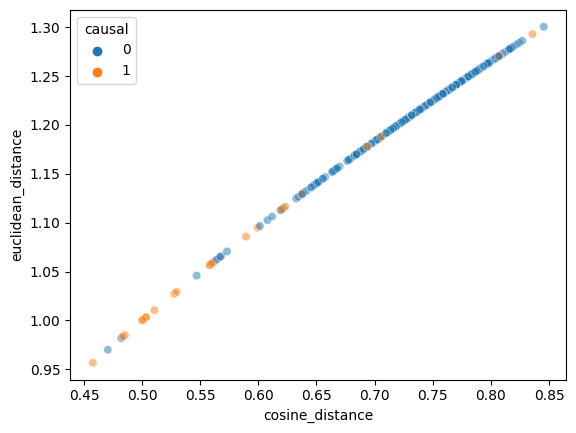

In [90]:
sns.scatterplot(x='cosine_distance', y='euclidean_distance', hue = 'causal', data = type_2_diabetes, alpha=0.5)
plt.show()

Majority of the causal genes seems to be having lower cosine distance as well as euclidean distance compared to the non causal genes, indicating that the causal genes are more similar to the phenotype.

For wrist fracture (a mono causal gene phenotype)

In [91]:
# Ectracting the required dataset
wrist_fracture = similarity_dataset[similarity_dataset['phenotype']=='wrist fracture (heel bone mineral density)']

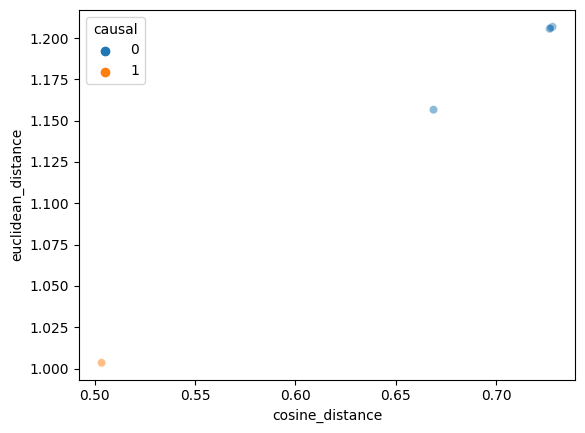

In [92]:
sns.scatterplot(x='cosine_distance', y='euclidean_distance', hue = 'causal', data = wrist_fracture, alpha=0.5)
plt.show()

The causal gene is having lower cosine distance as well as euclidean distance compared to the non causal genes, indicating that the causal genes are more similar to the phenotype.

Since a pattern is noticeable here, an overall pattern can be checked for the phenotypes and causal genes. 

In [93]:
# Creating function for plotting the similarity between phenotype and gene type
# Input --> number of plots, dataframe and the file name to save the plot
# Plots the scatterplots for all the unique phenotypes in the data and saves the plot
def similarity_plot(plots, data, file_name):
    cols = 4
    # calculating the required number of rows
    if plots%4 == 0:
        rows = int(plots/4)
    else:
        rows = int((plots//4)+1)
    
    fig, ax = plt.subplots(rows,cols,figsize=(80,80))
    for i,col_name in enumerate(data['phenotype'].unique()):
        row = i//cols # row index for the subplot
        col = i%cols # column index for the subplot
        plot_data = data[data['phenotype']==col_name] # extracting the required dataset for a particular phenotype
        sns.scatterplot(x='cosine_distance', y='euclidean_distance', hue = 'causal', data = plot_data, ax = ax[row,col]) # plotting the scatter plot
        ax[row,col].set_title(col_name)
    plt.tight_layout()
    plt.savefig(f'{file_name}.pdf', dpi=100) # saving the file
    plt.show()
            

Checking for multi-causal gene phenotypes

In [94]:
# Extracting the dataset with multiple causal genes
required_pheno = causal_gene_count[causal_gene_count['causal_gene_count'] > 1]['phenotype']
multi_causal_gene = similarity_dataset[similarity_dataset['phenotype'].isin(required_pheno)]

In [95]:
# Plotting the graphs
plots = multi_causal_gene['phenotype'].nunique() # number of plots 
similarity_plot(plots = plots, data = multi_causal_gene, file_name = 'Multi_causal_gene_similarity')

If not all, a considerable majority of the causal genes have lower cosine and euclidean distance compared to non-causal genes for a particular phenotype. It can be safely said that the causal genes are more similar to their phenotypes. Please check this for full view - [[link]](https://drive.google.com/file/d/1XqPXZ9kuQiTp67YBN-c_Le8I3D7h7tZK/view?usp=sharing)

Checking for mono-causal gene phenotype

In [96]:
# Extracting the dataset with mono causal genes
required_pheno = causal_gene_count[causal_gene_count['causal_gene_count'] == 1]['phenotype']
mono_causal_gene = similarity_dataset[similarity_dataset['phenotype'].isin(required_pheno)]

In [97]:
# Plotting the graphs
plots = mono_causal_gene['phenotype'].nunique() # number of plots
similarity_plot(plots = plots, data = mono_causal_gene, file_name = 'Mono_causal_gene_similarity')

Similar to previous one, a considerable majority of the causal gene have lower cosine and euclidean distance, thus stating that the causal genes are similar to their respective phenotypes. Please check this for full view - [[link]](http://drive.google.com/file/d/1bEIRpK35R85-d2FnmPbu7LbBqI3qKGq1/view?usp=sharing)

##### Thus a pattern of higher similarity between phenotype and its causal genes compared to non-causal genes is present

### Clustering

In this section we will check whether the causal genes cluster together with their phenotypes. The t-SNE derived dimensionality will be used here.<br>Given the similarity pattern observed in the above case, the clustering should also resemble a similar pattern.

For Type 2 diabetes (a multi-causal gene phenotype)

In [98]:
#Extracting the required dataset
type_2_diabetes = final_dataset[final_dataset['phenotype']=='Type 2 diabetes (type II diabetes mellitus)']
#Removing unwanted colmns
type_2_diabetes = type_2_diabetes.drop(columns = ['pheno_embedding', 'gene_embedding'])
#removing duplicates based on phenotype, gene and causal label
type_2_diabetes = type_2_diabetes.drop_duplicates(subset=['phenotype','gene_composition','causal'], keep = 'first').reset_index(drop=True)
type_2_diabetes.shape

(346, 7)

In [99]:
type_2_diabetes.head()

phenotype gene_composition  causal  \
0  Type 2 diabetes (type II diabetes mellitus)            CAND2       0   
1  Type 2 diabetes (type II diabetes mellitus)  ENSG00000289809       0   
2  Type 2 diabetes (type II diabetes mellitus)            MKRN2       0   
3  Type 2 diabetes (type II diabetes mellitus)          MKRN2OS       0   
4  Type 2 diabetes (type II diabetes mellitus)            PPARG       1   

   pheno_tsne_1  pheno_tsne_2  gene_tsne_1  gene_tsne_2  
0    -39.246365    -57.288761     1.527184    43.051624  
1    -39.246365    -57.288761    -4.295242    86.582314  
2    -39.246365    -57.288761     1.473026    52.293861  
3    -39.246365    -57.288761     1.455780    52.184788  
4    -39.246365    -57.288761     9.321151   -34.420490

In [100]:
# Combining the dimensions of the phenotype and genes in a column for clustering
# Creating database of the gene dimensions 
gene_dataset = type_2_diabetes[['gene_composition','causal','gene_tsne_1','gene_tsne_2']]
gene_dataset = gene_dataset.rename(columns={'gene_composition':'Name','gene_tsne_1':'tsne_1','gene_tsne_2':'tsne_2'})
# Creating database for phenotype dimensions
pheno_dataset = type_2_diabetes[['phenotype','pheno_tsne_1','pheno_tsne_2']]
pheno_dataset = pheno_dataset.drop_duplicates(keep='first')
pheno_dataset = pheno_dataset.rename(columns={'phenotype':'Name','pheno_tsne_1':'tsne_1','pheno_tsne_2':'tsne_2'})
pheno_dataset['causal'] = 'Pheno'
# Concating both the dataset to create the final dataset
cluster_dataset = pd.concat([pheno_dataset,gene_dataset])
cluster_dataset.head(6)

Name     tsne_1     tsne_2 causal
0  Type 2 diabetes (type II diabetes mellitus) -39.246365 -57.288761  Pheno
0                                        CAND2   1.527184  43.051624      0
1                              ENSG00000289809  -4.295242  86.582314      0
2                                        MKRN2   1.473026  52.293861      0
3                                      MKRN2OS   1.455780  52.184788      0
4                                        PPARG   9.321151 -34.420490      1

In [101]:
from sklearn.cluster import KMeans

Creating only two clusters as the target is to check if the causal genes cluster with the phenotype 

In [102]:
# Extracting the dimensions for clustering input
dimensions = cluster_dataset[['tsne_1','tsne_2']].astype(np.float64)
#Initiating Kmeans clustering with 2 clusters
kmeans = KMeans(n_clusters = 2, random_state=42)
kmeans.fit(dimensions)

KMeans(n_clusters=2, random_state=42)

Plotting the cluster along with the contour lines for cluster boundaries

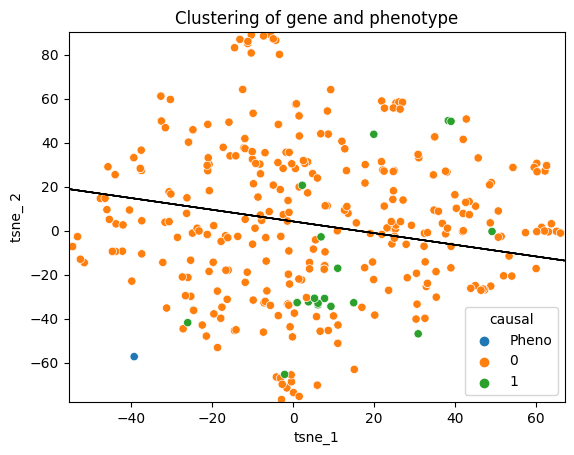

In [103]:
# Creating a mesh grid to plot cluster boundaries
X = np.array(dimensions)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predicting the cluster labels for each point on the grid
grid_points = np.c_[xx.ravel(), yy.ravel()].astype(np.float64) #converting to float64 as the model is trained in it
Z = kmeans.predict(grid_points)
Z = Z.reshape(xx.shape)

# Ploting the contour lines for cluster boundaries
plt.contour(xx, yy, Z, colors='black', linewidths=1)

# Ploting the original data points and coloring them by the causal label
sns.scatterplot(x='tsne_1', y='tsne_2', hue='causal', data = cluster_dataset)

plt.xlabel('tsne_1')
plt.ylabel('tsne_ 2')
plt.title('Clustering of gene and phenotype')

plt.show()

Majority of the causal genes are clustered together with the phenotype, indicating a greater similarity between the phenotype and its causal gene compared to the non-causal gene

### Classifier modelling

#### Categories:<br><br>non-causal --> 0<br>causal --> 1

In [104]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [105]:
#Creating the dataset
clf_dataset = similarity_dataset[['causal','cosine_distance','euclidean_distance']]
clf_dataset['causal'].value_counts()

causal
0    4974
1     329
Name: count, dtype: int64

As the data has less number of category 1, proper distribution of the train and test dataset is required so that the model is exposed to all categories properly 

In [106]:
# Seperating the causal gene from the non-causal gene and creating the features and target datasets accordingly

causal_gene = clf_dataset[clf_dataset['causal']==1] # causal dataset
non_causal_gene = clf_dataset[clf_dataset['causal']==0] # non-causal dataset
feature_0 = non_causal_gene.drop(columns = 'causal') #features of non-causal dataset
target_0 = non_causal_gene['causal'] # category of non-causal dataset
feature_1 = causal_gene.drop(columns = 'causal') # features of causal dataset
target_1 = causal_gene['causal'] # category of causal dataset

In [107]:
x_train_0, x_test_0, y_train_0, y_test_0 = train_test_split(feature_0, target_0, test_size = 0.2) # splitting the non-causal dataset
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(feature_1, target_1, test_size = 0.2) # splitting the causal dataset

In [108]:
# Merging the split datasets accordingly to get the final train and test dataset
# This is done to ensure a proper amount of both the categories are present in the test and train dataset
x_train = pd.concat([x_train_0,x_train_1])
y_train = pd.concat([y_train_0,y_train_1])
x_test = pd.concat([x_test_0,x_test_1])
y_test = pd.concat([y_test_0,y_test_1])

# Shuffling the datasets so that the model sees datapoints randomly. The seed value has been used to keep the shuffling consistent throughout datasets.
x_train = x_train.sample(frac=1,random_state=seed)
y_train = y_train.sample(frac=1,random_state=seed)
x_test = x_test.sample(frac=1,random_state=seed)
y_test = y_test.sample(frac=1,random_state=seed)

In [109]:
#Initiating the Support vector classifier model and tunning the hyperparameters along with cross validation using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],           # Regularization parameter
    'gamma': ['scale', 0.001, 0.01],  # Kernel coefficient
}

svc = SVC(kernel = 'rbf', random_state = seed) # a non-linear kernel is used for classifying as the features show a linear plot in base dimension
clf = GridSearchCV(estimator = svc, param_grid = param_grid, cv = 4, scoring = 'accuracy')
clf.fit(x_train,y_train)
print(f'Best parameters --> {clf.best_params_}\nBest score --> {clf.best_score_}')

Best parameters --> {'C': 100, 'gamma': 'scale'}
Best score --> 0.9457800579730763


In [110]:
# predicting and calculating accuracy
pred = clf.predict(x_test)
acc = round(accuracy_score(y_test,pred)*100,2)
print(f'Accuracy on test set --> {acc}%')

Accuracy on test set --> 94.44%


In [111]:
# Calculating the classification matrix
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       995
           1       0.64      0.24      0.35        66

    accuracy                           0.94      1061
   macro avg       0.80      0.62      0.66      1061
weighted avg       0.93      0.94      0.93      1061



##### Even though the accuracy seems high, upon checking the f1-scores, a very poor fi-score is evaluated for the causal(1) category. This is most probably because of the less number of causal genes present in the data which has led to a bias for the non-causal category. 